In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
# ----------------------
# Data Preprocessing
# ----------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


Training Basic GAN (Before Mitigation)...

Epoch [1/10] - D Loss: 0.1790, G Loss: 4.4293
Epoch [2/10] - D Loss: 1.5755, G Loss: 12.1220
Epoch [3/10] - D Loss: 0.1433, G Loss: 6.3917
Epoch [4/10] - D Loss: 1.3479, G Loss: 1.8336
Epoch [5/10] - D Loss: 0.2312, G Loss: 4.4080
Epoch [6/10] - D Loss: 0.1452, G Loss: 5.0262
Epoch [7/10] - D Loss: 0.6110, G Loss: 5.1592
Epoch [8/10] - D Loss: 1.1048, G Loss: 4.4689
Epoch [9/10] - D Loss: 0.2597, G Loss: 5.2970
Epoch [10/10] - D Loss: 0.3249, G Loss: 3.3152

Training Improved GAN (After Mitigation)...

Epoch [1/10] - D Loss: 0.9312, G Loss: 1.8034
Epoch [2/10] - D Loss: 0.5681, G Loss: 2.1561
Epoch [3/10] - D Loss: 0.8776, G Loss: 1.6487
Epoch [4/10] - D Loss: 0.9908, G Loss: 2.0358
Epoch [5/10] - D Loss: 0.8593, G Loss: 2.2568
Epoch [6/10] - D Loss: 0.9453, G Loss: 2.3049
Epoch [7/10] - D Loss: 0.9551, G Loss: 2.3856
Epoch [8/10] - D Loss: 0.6424, G Loss: 2.0509
Epoch [9/10] - D Loss: 0.7385, G Loss: 1.9631
Epoch [10/10] - D Loss: 0.4548, G 

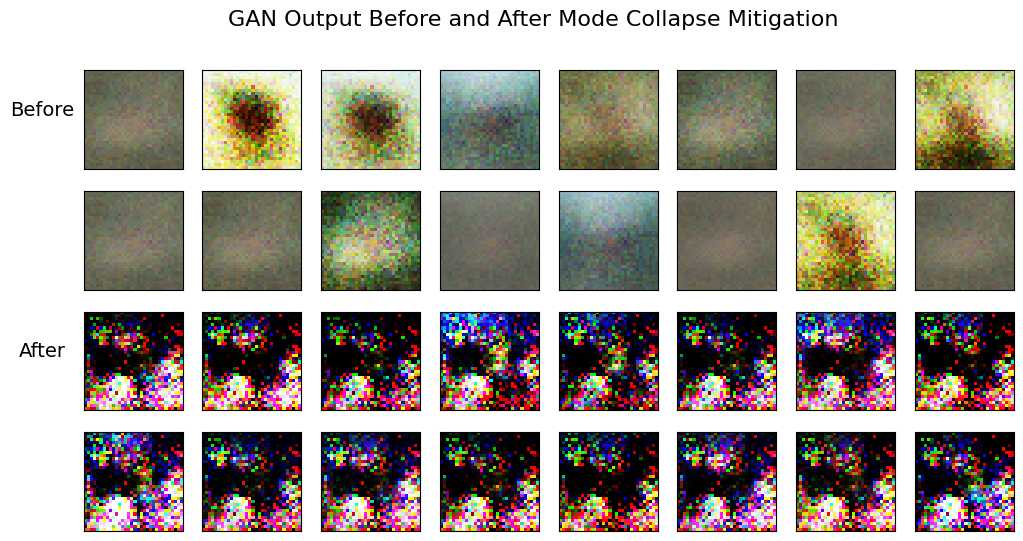

In [2]:
# ----------------------
# Define GAN Models
# ----------------------
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 32 * 32),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 3, 32, 32)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3 * 32 * 32, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(-1, 3 * 32 * 32))

# ----------------------
# Mode Collapse Mitigation Functions
# ----------------------
def label_smoothing(labels, smooth_factor=0.1):
    return labels * (1 - smooth_factor) + smooth_factor / 2

def feature_matching_loss(fake_images, real_images):
    return torch.mean((fake_images.mean(dim=0) - real_images.mean(dim=0)) ** 2)

def mini_batch_discrimination(batch):
    batch_size = batch.shape[0]
    batch_flattened = batch.view(batch_size, -1)
    mean_features = batch_flattened.mean(dim=0)
    std_features = batch_flattened.std(dim=0)
    batch_diff = (batch_flattened - mean_features) / (std_features + 1e-6)
    return batch_diff  # Same shape as input

# ----------------------
# Initialize Models, Loss, Optimizers
# ----------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# ----------------------
# Train Basic GAN (Before Mitigation)
# ----------------------
num_epochs = 10
print("\nTraining Basic GAN (Before Mitigation)...\n")
for epoch in range(num_epochs):
    for real_images, _ in dataloader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output, real_labels)

        z = torch.randn(batch_size, 100).to(device)
        fake_images = generator(z)
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_images)
        g_loss = criterion(fake_output, real_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# Generate images before mitigation
z = torch.randn(16, 100).to(device)
fake_images_before = generator(z).detach().cpu()

# ----------------------
# Train Improved GAN (After Mitigation)
# ----------------------
print("\nTraining Improved GAN (After Mitigation)...\n")
for epoch in range(num_epochs):
    for real_images, _ in dataloader:
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_labels = label_smoothing(torch.ones(batch_size, 1)).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        real_images = mini_batch_discrimination(real_images)
        real_output = discriminator(real_images)
        d_loss_real = criterion(real_output, real_labels)

        z = torch.randn(batch_size, 100).to(device)
        fake_images = generator(z)
        fake_images = mini_batch_discrimination(fake_images)
        fake_output = discriminator(fake_images.detach())
        d_loss_fake = criterion(fake_output, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_images)

        g_loss = criterion(fake_output, label_smoothing(torch.ones(batch_size, 1)).to(device))

        # Feature Matching Loss
        g_loss += feature_matching_loss(fake_images, real_images)

        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] - D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

# Generate images after mitigation
z = torch.randn(16, 100).to(device)
fake_images_after = generator(z).detach().cpu()

# ----------------------
# Compare Before and After Mitigation
# ----------------------
fig, axes = plt.subplots(4, 8, figsize=(12, 6))

# Before mitigation
for i, ax in enumerate(axes[:2].flat):
    img = fake_images_before[i].permute(1, 2, 0)
    ax.imshow((img + 1) / 2)  # Convert back to [0,1] range
    ax.set_xticks([])
    ax.set_yticks([])

# After mitigation
for i, ax in enumerate(axes[2:].flat):
    img = fake_images_after[i].permute(1, 2, 0)
    ax.imshow((img + 1) / 2)  # Convert back to [0,1] range
    ax.set_xticks([])
    ax.set_yticks([])

axes[0, 0].set_ylabel("Before", fontsize=14, rotation=0, labelpad=30)
axes[2, 0].set_ylabel("After", fontsize=14, rotation=0, labelpad=30)
plt.suptitle("GAN Output Before and After Mode Collapse Mitigation", fontsize=16)
plt.show()
